# Label CD4 T cell types

In this notebook, we'll retrieve the CD4 T cell Seurat object, label using the Azimuth cell type reference to guide labeling, then integrate and use ADT and Gene markers to label CD4 cell types.

## Load packages

hise: The Human Immune System Explorer R SDK package  
purrr: Functional programming tools  
dplyr: Dataframe handling functions  
ggplot2: plotting functions  
Seurat: single cell genomics methods

In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(hise)
quiet_library(purrr)
quiet_library(dplyr)
quiet_library(ggplot2)
quiet_library(Seurat)

## Retrieve files

Now, we'll use the HISE SDK package to retrieve the Seurat object based on its UUID. This will be placed in the `cache/` subdirectory by default.

In [2]:
cd4_so_uuid <- list("50756d6d-8216-4eba-8245-0a41d4f44e7a")

In [3]:
fres <- cacheFiles(cd4_so_uuid)

We'll also need the Azimuth reference for label transfer. We can retrieve these files from this Zenodo entry:  
https://zenodo.org/record/4546839

This Reference dataset is based on this paper from the Satija lab:  
https://pubmed.ncbi.nlm.nih.gov/34062119/

In [4]:
dir.create("reference")

Warning message in dir.create("reference"):
“'reference' already exists”


In [5]:
options(timeout = 100000)
download.file(
    "https://zenodo.org/record/4546839/files/ref.Rds?download=1",
    "reference/pbmc_reference.rds"
)

## Prepare reference

Since our data consists of only CD4 T cells, we'll remove the other cell types from the reference prior to performing label transfer

In [6]:
ref <- readRDS("reference/pbmc_reference.rds")

In [7]:
table(ref$celltype.l1)


      B   CD4 T   CD8 T      DC    Mono      NK   other other T 
   2698   17646    5858     922    4564    2051    1078    1616 

In [8]:
ref <- ref[,ref$celltype.l1 == "CD4 T"]

In [9]:
ref

An object of class Seurat 
5228 features across 17646 samples within 2 assays 
Active assay: refAssay (5000 features, 0 variable features)
 1 layer present: data
 1 other assay present: ADT
 2 dimensional reductions calculated: refUMAP, refDR

## Prepare dataset

The reference uses SCTransformed data. To enable label transfer, we'll run `SCTransform()` from the Seurat package to transform our data. We only need to do this on the set of features that are present in the reference.

We can also regress treatment and timepoint as we're most interested in cell type for label transfer, not the variation generated by treatment conditions.

In [10]:
so <- readRDS("cache/50756d6d-8216-4eba-8245-0a41d4f44e7a/filtered_cd4_te_seurat.rds")

In [11]:
so <- SCTransform(
    so,
    residual.features = rownames(ref),
    vars.to.regress = c("cohort.cohortGuid")
)

Running SCTransform on assay: RNA

Running SCTransform on layer: counts

Computing residuals for the 5000 specified features

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 28891 by 57321

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Found 418 outliers - those will be ignored in fitting/regularization step


Skip calculation of full residual matrix

Calculating gene attributes

Wall clock passed: Time difference of 20.40968 secs

Determine variable features

Setting min_variance based on median UMI:  0.04

Calculating residuals of type pearson for 4808 genes



  |======================================================================| 100%


Regressing out cohort.cohortGuid

Centering data matrix

Getting residuals for block 1(of 12) for counts dataset

Getting residuals for block 2(of 12) for counts dataset

Getting residuals for block 3(of 12) for counts dataset

Getting residuals for block 4(of 12) for counts dataset

Getting residuals for block 5(of 12) for counts dataset

Getting residuals for block 6(of 12) for counts dataset

Getting residuals for block 7(of 12) for counts dataset

Getting residuals for block 8(of 12) for counts dataset

Getting residuals for block 9(of 12) for counts dataset

Getting residuals for block 10(of 12) for counts dataset

Getting residuals for block 11(of 12) for counts dataset

Getting residuals for block 12(of 12) for counts dataset

Regressing out cohort.cohortGuid

Centering data matrix

Finished calculating residuals for counts

Set default assay to SCT



In [12]:
length(VariableFeatures(so))

[1] 4808

## Transfer Labels

With the transformed data, we'll run anchor-based integration.

In [13]:
anchors <- FindTransferAnchors(
    reference = ref,
    query = so,
    features = VariableFeatures(so),
    normalization.method = "SCT",
    reference.reduction = "refDR",
    dims = 1:50,
    recompute.residuals = FALSE,
    verbose = FALSE
)

In [14]:
so <- suppressWarnings(
    MapQuery(
      anchorset = anchors,
      query = so,
      reference = ref,
      refdata = list(
        celltype.l1   = "celltype.l1",
        celltype.l2 = "celltype.l2",
        celltype.l3  = "celltype.l3"
      ),
      verbose = FALSE
    )
)

## Dimensionality reduction and visualization

To visualize results, we'll perform PCA and UMAP

In [15]:
so <- RunPCA(so, verbose = FALSE)

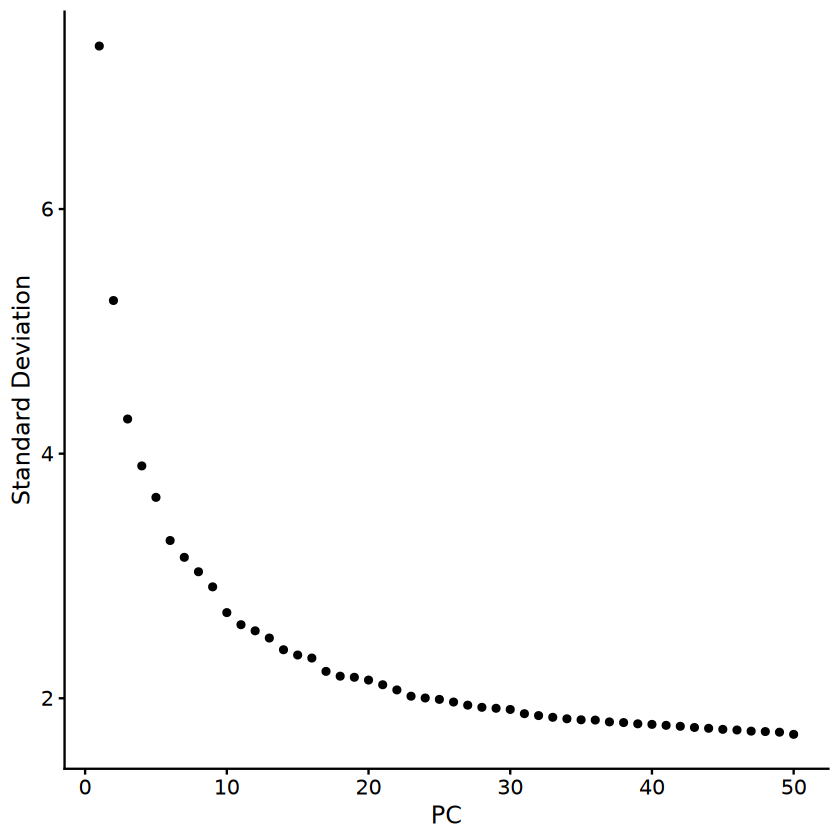

In [16]:
ElbowPlot(so, ndims = 50)

In [17]:
so <- FindNeighbors(so, dims = 1:30, verbose = FALSE)
so <- FindClusters(so, resolution = 1.5, verbose = FALSE)

In [18]:
so <- RunUMAP(so, dims = 1:30, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



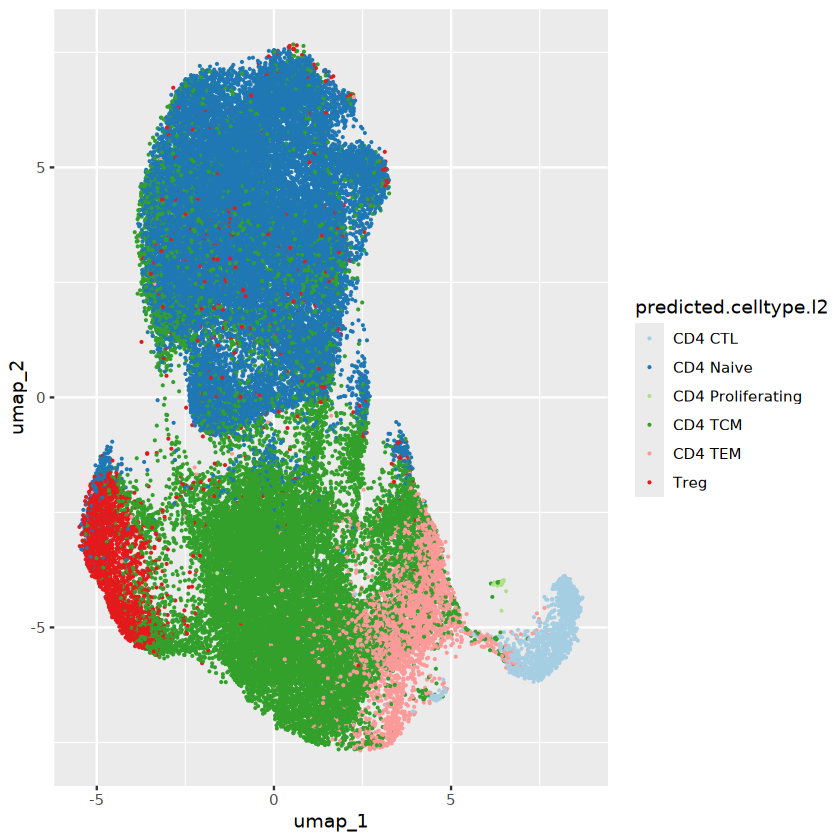

In [19]:
umap_df <- as.data.frame(so@reductions$umap@cell.embeddings)
umap_df <- cbind(so@meta.data, umap_df)

ggplot() +
  geom_point(
      data = umap_df,
      aes(x = umap_1,
          y = umap_2,
          color = predicted.celltype.l2),
      size = 0.1
  ) +
  scale_color_brewer(
      type = "qual",
      palette = 3
  )

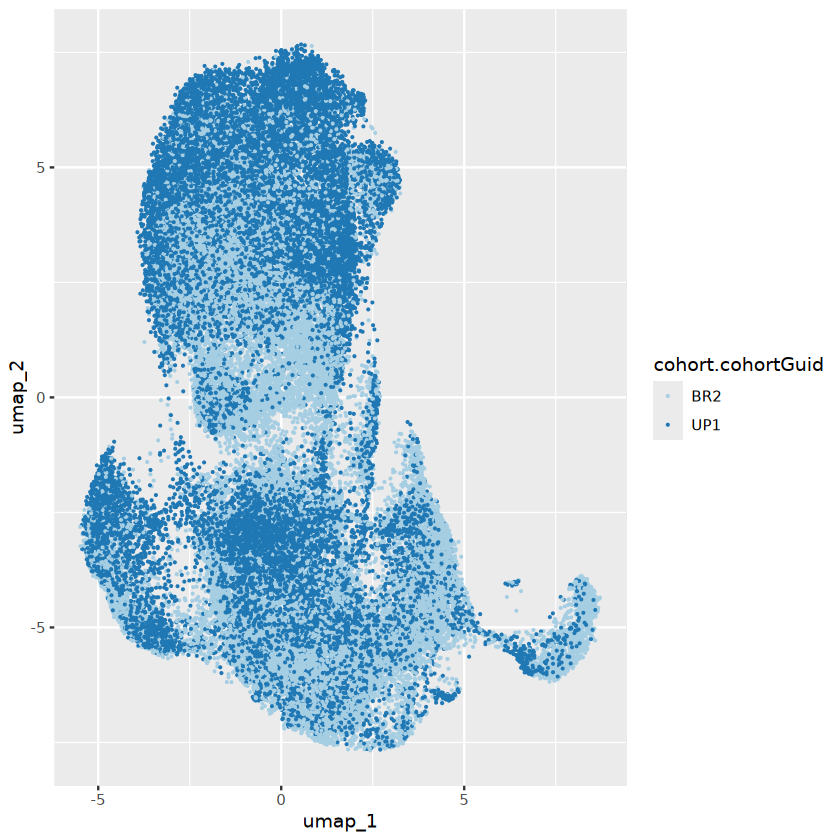

In [20]:
ggplot() +
  geom_point(
      data = umap_df,
      aes(x = umap_1,
          y = umap_2,
          color = cohort.cohortGuid),
      size = 0.1
  ) +
  scale_color_brewer(
      type = "qual",
      palette = 3
  )

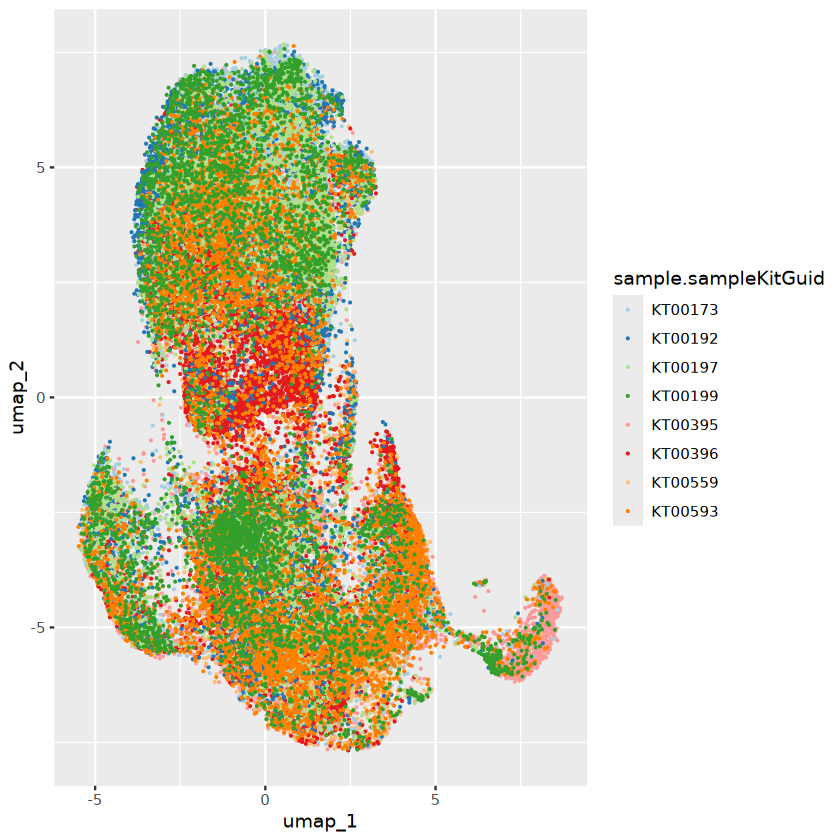

In [21]:
ggplot() +
  geom_point(
      data = umap_df,
      aes(x = umap_1,
          y = umap_2,
          color = sample.sampleKitGuid),
      size = 0.1
  ) +
  scale_color_brewer(
      type = "qual",
      palette = 3
  )

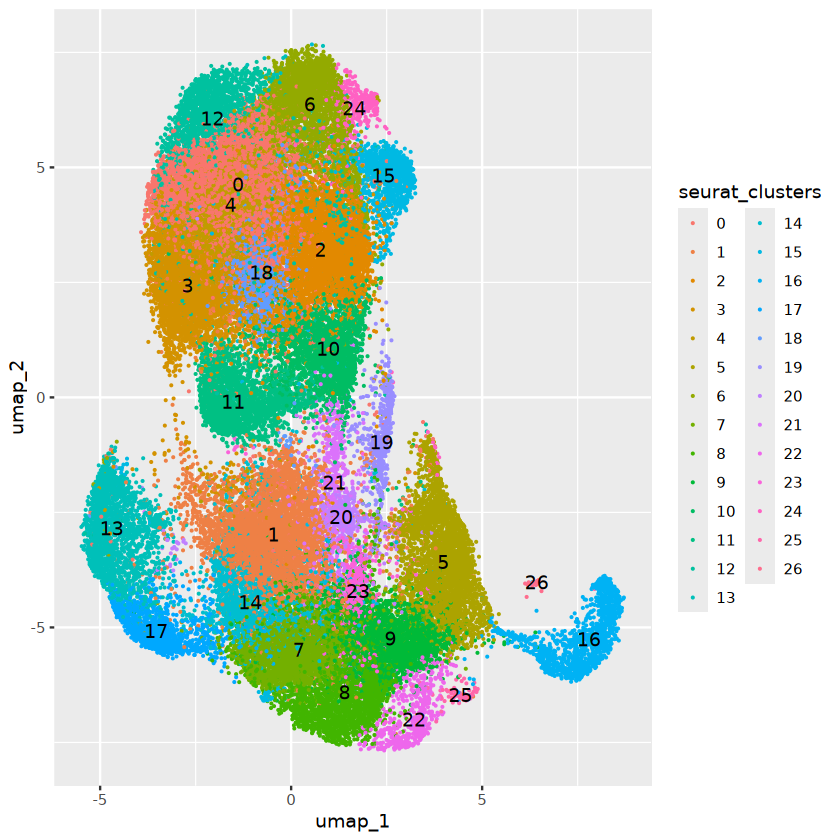

In [22]:
cl_df <- umap_df %>%
  group_by(seurat_clusters) %>%
  summarize(umap_1 = median(umap_1),
            umap_2 = median(umap_2))
ggplot() +
  geom_point(
      data = umap_df,
      aes(x = umap_1,
          y = umap_2,
          color = seurat_clusters),
      size = 0.1
  ) +
  geom_text(
      data = cl_df ,
      aes(x = umap_1,
          y = umap_2,
          label = seurat_clusters)
  )

In [23]:
DefaultAssay(so) <- "SCT"
type_markers <- c(
    "UBE2E2", # CD4 Naive 
    "MAF", # CD4 Memory
    "CCL5", # CD4 EM
    "FOXP3" # CD4 Treg
)

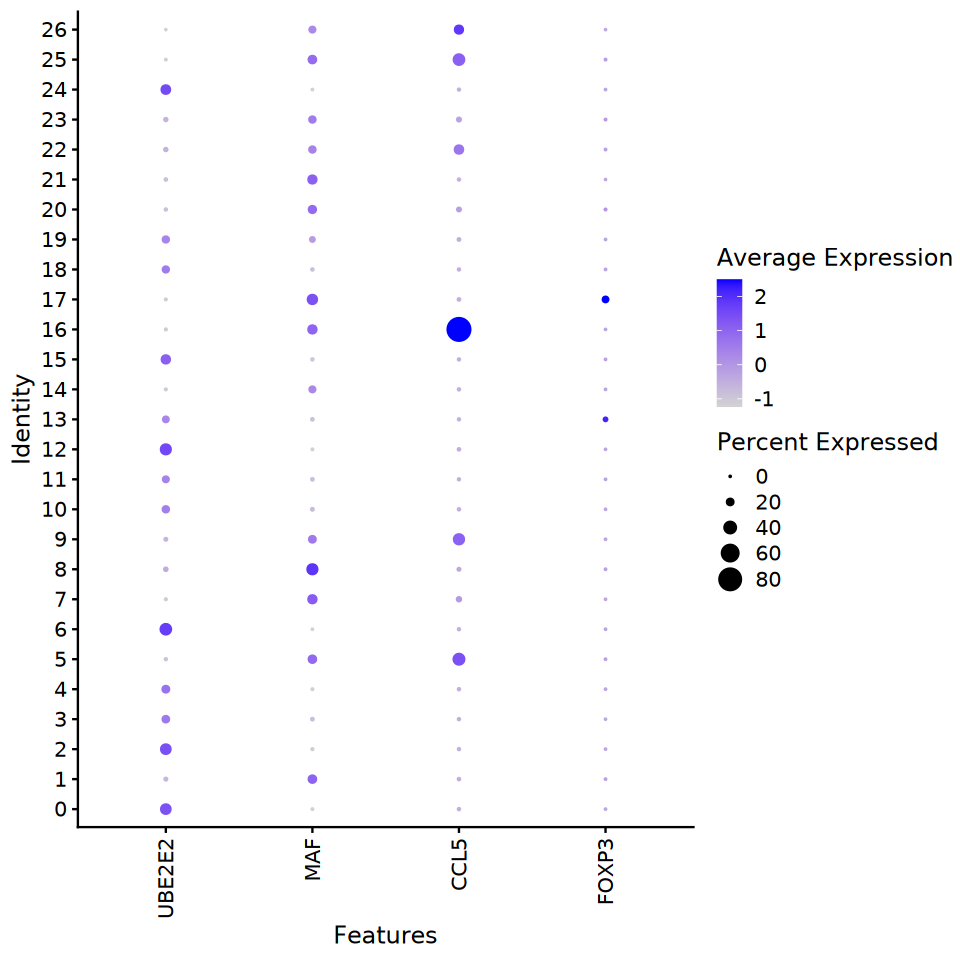

In [24]:
options(repr.plot.width = 8, repr.plot.height = 8)
DotPlot(
    so,
    features = type_markers,
    group.by = "seurat_clusters"
)  +
  ggplot2::theme(axis.text.x = ggplot2::element_text(angle = 90, hjust = 1, vjust = 0.5))

We'll apply these cutoffs to assign cell types

In [25]:
# Naive CD4:
ube2e2_cutoff <- 0.1
# CD4 CM:
maf_cutoff <- 0.15
# CD4 EM:
ccl5_cutoff <- 0.15
# CD4 Treg
foxp3_cutoff <- 0.05

In [26]:
marker_mat <- so[["RNA"]]@layers$counts[match(type_markers, so[["RNA"]]@features@dimnames[[1]]),]
rownames(marker_mat) <- type_markers
colnames(marker_mat) <- colnames(so)
clusters <- so@meta.data$seurat_clusters

In [27]:
marker_fracs <- map(
    type_markers,
    function(marker) {
        cl_list <- split(marker_mat[marker,], clusters)
        cl_frac <- map_dbl(cl_list, function(x) { sum(x > 0) / length(x) })
        cl_frac
    })
names(marker_fracs) <- type_markers
marker_df <- data.frame(
    cl = names(marker_fracs[[1]]),
    do.call(cbind, marker_fracs)
)

In [28]:
cl_types <- marker_df %>%
  mutate(
      aifi_cell_type = case_when(
          FOXP3 > foxp3_cutoff ~ "t_cd4_treg",
          CCL5 > ccl5_cutoff ~ "t_cd4_em",
          MAF > maf_cutoff ~ "t_cd4_cm",
          UBE2E2 > ube2e2_cutoff ~ "t_cd4_naive"
      )
  )

In [29]:
cl_types

,cl,UBE2E2,MAF,CCL5,FOXP3,aifi_cell_type
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,0,0.313344438,0.010734777,0.03164908,0.0024060707,t_cd4_naive
1,1,0.056585366,0.232780488,0.03687805,0.0054634146,t_cd4_cm
2,2,0.314516129,0.019230769,0.02729529,0.0028949545,t_cd4_naive
3,3,0.196126502,0.045844570,0.03015445,0.0009806325,t_cd4_naive
4,4,0.202874516,0.013819790,0.03067993,0.0033167496,t_cd4_naive
5,5,0.028218695,0.231628454,0.36654909,0.0058788948,t_cd4_em
6,6,0.353253652,0.004316069,0.02822045,0.0029880478,t_cd4_naive
7,7,0.017423984,0.259651520,0.10761872,0.0023915272,t_cd4_cm
8,8,0.075636640,0.332193082,0.05245154,0.0060813379,t_cd4_cm


In [30]:
so@meta.data$aifi_cell_type <- cl_types$aifi_cell_type[match(so@meta.data$seurat_clusters, cl_types$cl)]

In [31]:
umap_df$aifi_cell_type <- so@meta.data$aifi_cell_type

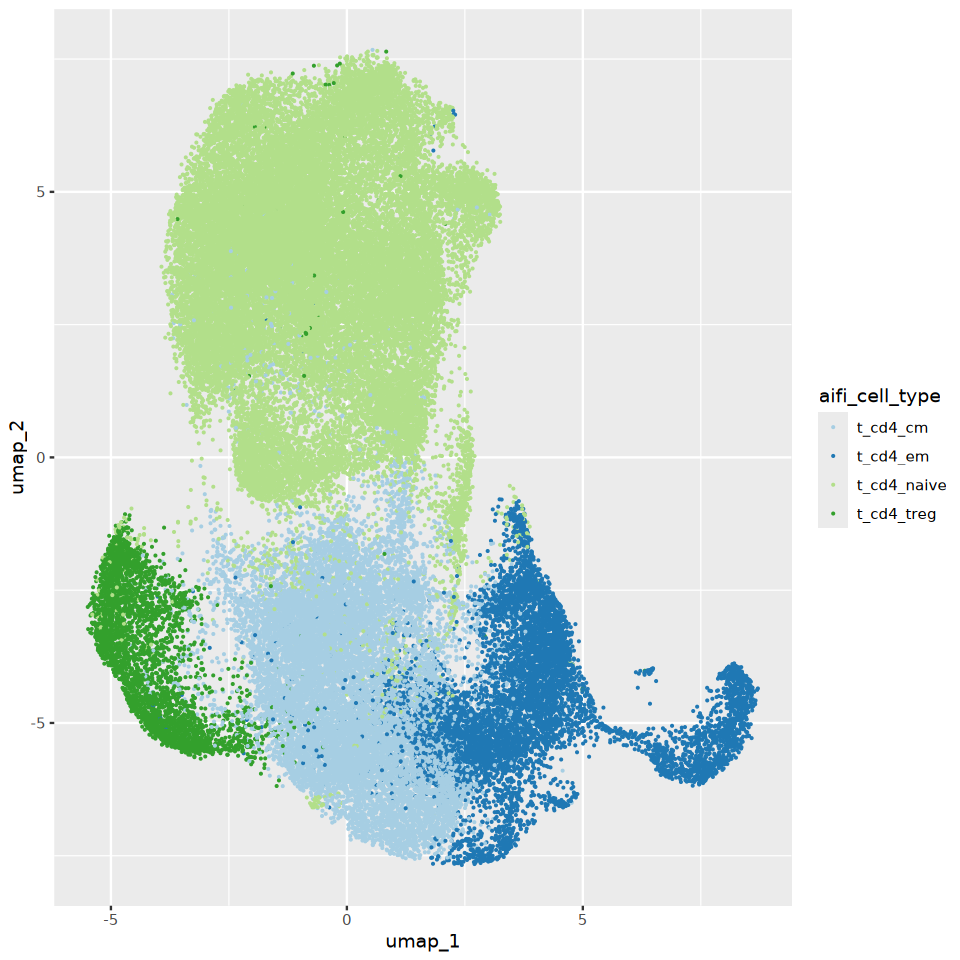

In [32]:
ggplot() +
  geom_point(
      data = umap_df,
      aes(x = umap_1,
          y = umap_2,
          color = aifi_cell_type),
      size = 0.1
  ) +
  scale_color_brewer(
      type = "qual",
      palette = 3
  )

In [33]:
so_meta <- so@meta.data
rownames(so_meta) <- so_meta$barcodes
so@meta.data <- so_meta

In [34]:
type_counts <- table(
    so_meta$subject.subjectGuid,
    so_meta$aifi_cell_type
)
type_counts

        
         t_cd4_cm t_cd4_em t_cd4_naive t_cd4_treg
  BR2002     2225     1615        2854        361
  BR2005     2687     2471        4435        621
  BR2015     1704      628        5916        285
  BR2042     2170     1301        3037        334
  UP1001     1366      630        2369        457
  UP1006     1312      452        4902        435
  UP1007     1318      427        3481        451
  UP1010     1335      471        4764        507

In [35]:
prop.table(type_counts, 1)

        
           t_cd4_cm   t_cd4_em t_cd4_naive t_cd4_treg
  BR2002 0.31537916 0.22891566  0.40453579 0.05116938
  BR2005 0.26307030 0.24192285  0.43420795 0.06079890
  BR2015 0.19969530 0.07359662  0.69330833 0.03339974
  BR2042 0.31715873 0.19014908  0.44387606 0.04881614
  UP1001 0.28328494 0.13065118  0.49128992 0.09477395
  UP1006 0.18476271 0.06365301  0.69032531 0.06125898
  UP1007 0.23216488 0.07521578  0.61317597 0.07944337
  UP1010 0.18863925 0.06655362  0.67316660 0.07164053

## Generate output files

For downstream use, we'll output the table of aifi_cell_type labels for each cell.

In [36]:
dir.create("output")

Warning message in dir.create("output"):
“'output' already exists”


In [37]:
out_labels <- so_meta %>%
  select(barcodes, sample.sampleKitGuid, starts_with("predicted"), aifi_cell_type)

In [38]:
write.csv(out_labels,
          paste0("output/cd4_cell_type_labels_",Sys.Date(),".csv"),
          quote = FALSE, row.names = FALSE)

## Store results in HISE

Finally, we store the output file in our Collaboration Space for later retrieval and use. We need to provide the UUID for our Collaboration Space (aka `studySpaceId`), as well as a title for this step in our analysis process.

The hise function `uploadFiles()` also requires the FileIDs from the original fileset for reference. For this analysis, we used just one input file, defined in `cd4_so_uuid`.

In [39]:
study_space_uuid <- "00a53fa5-18da-4333-84cb-3cc0b0761201"
title <- paste0("TEA-seq demo CD4 labels ", Sys.Date())

In [40]:
search_id <- ids::adjective_animal()
search_id

[1] "oligoantigenic_bichonfrise"

In [41]:
out_files <- list.files(
    "output",
    full.names = TRUE
)
out_list <- as.list(out_files)

In [42]:
out_list

[[1]]
[1] "output/cd4_cell_type_labels_2024-06-29.csv"

In [43]:
uploadFiles(
    files = out_list,
    studySpaceId = study_space_uuid,
    title = title,
    inputFileIds = cd4_so_uuid,
    store = "project",
    destination = search_id,
    doPrompt = FALSE
)

[1] "Cannot determine the current notebook."
[1] "1) /home/jupyter/certpro-workflow-demos/adult_vs_pediatric_teaseq/06-R_cd4_type_labeling.ipynb"
[1] "2) /home/jupyter/certpro-workflow-demos/adult_vs_pediatric_teaseq/07-R_cd8_type_labeling.ipynb"
[1] "3) /home/jupyter/certpro-workflow-demos/adult_vs_pediatric_teaseq/05-R_t_cell_class_filtering.ipynb"


Please select (1-3)  1


$files
$files[[1]]
[1] "output/cd4_cell_type_labels_2024-06-29.csv"


$traceId
[1] "63fee296-1c32-4a43-b753-d8890284b3bb"

In [44]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.25.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] Seurat_5.1.0       SeuratObject_5.0.2 sp_2.1-2           ggplot2_3.5.1     
[5] dplyr_1.1.4        purrr_1.0.2        hise_2.16.0       

loaded via a namespace (and not attached):
  [1] RColorBrewer_1.1-3          jsonlite_1.8.8             
  [3] magrittr_2.0.3              spatstat.utils_3.0-4       
  [5